### Doc2Vec

Doc2vec is an adaptation of Word2Vec that allows us to learn document similarity. Doc2vec model by itself is an unsupervised method.

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('Consumer_Complaints.csv')
df = df[['Consumer complaint narrative','Product']]
df = df[pd.notnull(df['Consumer complaint narrative'])]
df.head(10)

Consumer complaint narrative  \
1   When my loan was switched over to Navient i wa...   
2   I tried to sign up for a spending monitoring p...   
7   My mortgage is with BB & T Bank, recently I ha...   
14  The entire lending experience with Citizens Ba...   
15  My credit score has gone down XXXX points in t...   
17  I few months back I contacted XXXX  in regards...   
28  I '' m a victim of fraud and I have a file wit...   
30  My mortgage is owned by XXXX, we have painfull...   
32  I have been disputing a Bankruptcy on my credi...   
54  Today I received a phone call from a number li...   

                                              Product  
1                                        Student loan  
2                         Credit card or prepaid card  
7                                            Mortgage  
14                                           Mortgage  
15                                   Credit reporting  
17  Credit reporting, credit repair services, or o...  
28  Credit reporting, credit repair services, or o...  
30                                           Mortgage  
32  Credit reporting, credit repair services, or o...  
54                                    Debt collection

In [4]:
df.shape

(318718, 2)

In [5]:
df.isnull().sum()

Consumer complaint narrative    0
Product                         0
dtype: int64

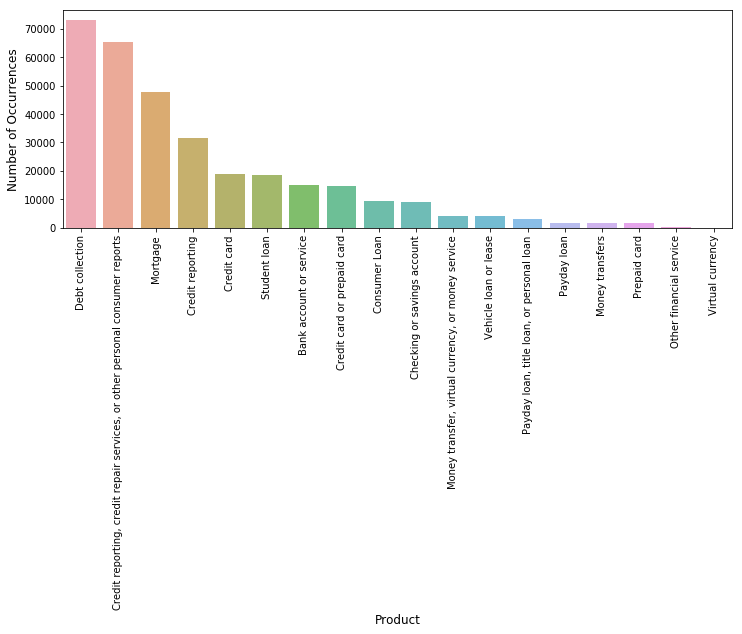

In [6]:
cnt_pro = df['Product'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=90)
plt.show();

The classes are imbalanced. However, a naive classifier that predicts everything to be Debt collection will only achieve over 20% accuracy.

### Text preprocessing

Below we define a function to convert text to lower-case and strip punctuation/symbols from words and so on.

In [7]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text

In [8]:
df['Consumer complaint narrative'] = df['Consumer complaint narrative'].apply(cleanText)

In [9]:
df['Consumer complaint narrative'][1]

'when my loan was switched over to navient i was never told that i had a deliquint balance because with  i did not. when going to purchase a vehicle i discovered my credit score had been dropped from the  into the . i have been faithful at paying my student loan. i was told that navient was the company i had delinquency with. i contacted navient to resolve this issue you and kept being told to just contact the credit bureaus and epalin the situation and maybe they could help me. i was so angry that i just hurried and paid the balance off and then after tried to dispute the delinquency with the credit bureaus. i have had so much trouble bringing my credit score back up.'

In [10]:
df.shape

(318718, 2)

Re-arrange the index of the table. 

In [11]:
df.index = range(318718)

In [12]:
df.head(10)

Consumer complaint narrative  \
0  when my loan was switched over to navient i wa...   
1  i tried to sign up for a spending monitoring p...   
2  my mortgage is with bb & t bank, recently i ha...   
3  the entire lending eperience with citizens ban...   
4  my credit score has gone down  points in the l...   
5  i few months back i contacted   in regards to ...   
6  i '' m a victim of fraud and i have a file wit...   
7  my mortgage is owned by , we have painfully de...   
8  i have been disputing a bankruptcy on my credi...   
9  today i received a phone call from a number li...   

                                             Product  
0                                       Student loan  
1                        Credit card or prepaid card  
2                                           Mortgage  
3                                           Mortgage  
4                                   Credit reporting  
5  Credit reporting, credit repair services, or o...  
6  Credit reporting, credit repair services, or o...  
7                                           Mortgage  
8  Credit reporting, credit repair services, or o...  
9                                    Debt collection

In [13]:
df.rename(columns = {'Consumer complaint narrative':'narrative'}, inplace = True)

In [14]:
df.head()

narrative  \
0  when my loan was switched over to navient i wa...   
1  i tried to sign up for a spending monitoring p...   
2  my mortgage is with bb & t bank, recently i ha...   
3  the entire lending eperience with citizens ban...   
4  my credit score has gone down  points in the l...   

                       Product  
0                 Student loan  
1  Credit card or prepaid card  
2                     Mortgage  
3                     Mortgage  
4             Credit reporting

Below, we define a function to label each complaint narrative. And the TaggedDocument is an object-type to encapsulate a text-example function that helps to associate a tag/number with each document of the training corpus. In our case, the tag is simply the zero based line number.

In [15]:
from gensim.models import doc2vec

def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the complaint narrative.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(doc2vec.TaggedDocument(v.split(), [label]))
    return labeled

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df.narrative, df.Product, random_state=0, test_size=0.3)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [17]:
len(all_data)

318718

Let's take a look at the training corpus.

In [18]:
all_data[:2]

[TaggedDocument(words=['i', 'am', 'having', 'trouble', 'repaying', 'my', 'student', 'loans', 'for', 'my', 'account', '.', 'due', 'to', 'economic', 'hardship', 'i', 'have', 'asked', 'for', 'an', 'income-driven', 'repayment', 'plan', 'and', 'received', 'an', 'offer', 'of', '{$180.00}', 'on', '2016.', 'however,', 'fed', 'loan', 'servicing', 'on', ',', '2016', 'sent', 'me', 'an', 'invoice', 'in', 'the', 'amount', 'of', '{$1300.00}', 'which', 'includes', 'an', 'amount', 'past', 'due', 'of', '{$610.00}', 'and', 'a', 'current', 'payment', 'of', '{$720.00}.', 'please', 'note', 'that', 'for', 'me', 'it', 'is', 'a', 'stretch', 'for', 'me', 'to', 'pay', 'the', 'income-driven', 'repayment', 'plan', 'and', 'received', 'an', 'offer', 'of', '{$180.00}', 'but', 'i', 'am', 'willing', 'to', 'do', 'the', 'sacrifice.', 'however,', 'it', 'would', 'be', 'a', 'financial', 'burden', 'to', 'pay', 'the', 'amount', 'asked', 'for', 'on', 'the', 'invoice', 'sent', 'by', 'fed', 'loan', 'servicing', 'on', ',', '2016

### Training the model

We'll instantiate a Doc2Vec model-Distributed Bag of Words (DBOW). In the Word2Vec architecture, the two algorithm names are “continuous bag of words” (cbow) and “skip-gram” (sg); in the Doc2Vec architecture, the corresponding algorithms are “distributed bag of words” (dbow) and “distributed memory” (dm).

### DBOW

DBOW is the Doc2Vec model analogous to Skip-gram model in Word2Vec. The paragraph vectors are obtained by training a neural network on the task of predicting a probability distribution of words in a paragraph given a randomly-sampled word from the paragraph.

Training a Doc2Vec model is rather straight forward in Gensim, we initialize the model and train for 30 epochs:

dm =0 means ‘distributed bag of words’ (DBOW), set min_count=2 means ignoring all words with total frequency lower than this, size=100 is dimensionality of the generated feature vectors, alpha=0.025 is the initial alpha rate, learning rate will linearly drop to min_alpha as training progresses. And then we build a vocabulary.

In [20]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

100%|██████████| 318718/318718 [00:00<00:00, 2537947.09it/s]


In [21]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 318718/318718 [00:00<00:00, 2913828.00it/s]


Wall time: 33min 18s


Define a function to get the vectors.

In [24]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [25]:
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

In [27]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(multi_class='multinomial', solver = 'lbfgs')
logreg.fit(train_vectors_dbow, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [28]:
logreg.score(test_vectors_dbow, y_test)

0.6882425535475234

In [29]:
model_dbow.save('d2v_model_dbow.doc2vec')

### Distributed Memory

Distributed Memory (DM) acts as a memory that remembers what is missing from the current context — or as the topic of the paragraph. While the word vectors represent the concept of a word, the document vector intends to represent the concept of a document.

We again instantiate a Doc2Vec model with a vector size with 100 words and iterating over the training corpus 30 times.

In [31]:
model_dm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dm.build_vocab([x for x in tqdm(all_data)])

100%|██████████| 318718/318718 [00:00<00:00, 1621798.90it/s]


In [32]:
%%time
for epoch in range(30):
    model_dm.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dm.alpha -= 0.002
    model_dm.min_alpha = model_dm.alpha

100%|██████████| 318718/318718 [00:00<00:00, 2408128.30it/s]


Wall time: 56min 23s


In [33]:
train_vectors_dm = get_vectors(model_dm, len(X_train), 300, 'Train')
test_vectors_dm = get_vectors(model_dm, len(X_test), 300, 'Test')

In [34]:
logreg.fit(train_vectors_dm, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [35]:
logreg.score(test_vectors_dm, y_test)

0.6646690930388219

In [36]:
model_dm.save('d2v_model_dm.doc2vec')

In [37]:
# model_dbow = Doc2Vec.load('d2v_model_dbow.doc2vec')
# model_dm = Doc2Vec.load('d2v_model_dm.doc2vec')
model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [38]:
def get_concat_vectors(model1,model2, corpus_size, vectors_size, vectors_type):
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = np.append(model1.docvecs[prefix],model2.docvecs[prefix])
    return vectors

In [39]:
train_vecs_dbow_dm = get_concat_vectors(model_dbow,model_dm, len(X_train), 600, 'Train')
test_vecs_dbow_dm = get_concat_vectors(model_dbow,model_dm, len(X_test), 600, 'Test')

In [40]:
%%time
logreg = LogisticRegression()
logreg.fit(train_vecs_dbow_dm, y_train)

Wall time: 19min 18s


In [41]:
logreg.score(test_vecs_dbow_dm, y_test)

0.7055199966532798